In [49]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize

In [42]:
FILES = {
    "nominal":  "yield-curve-rates-1990-2024.csv",
    "real": "par-real-yield-curve-rates-2003-2024.csv",
}

TENOR_MAP = {
    "1 Mo": 1/12, "2 Mo": 2/12, "3 Mo": 3/12, "6 Mo": 0.5,
    "1 Yr": 1, "2 Yr": 2, "3 Yr": 3, "5 Yr": 5, "7 Yr": 7,
    "10 Yr": 10, "20 Yr": 20, "30 Yr": 30,
}

def read_file(path, kind):
    df = pd.read_csv(path)
    df = df.rename(columns={"Date": "date"})
    df["date"] = pd.to_datetime(df["date"])
    cols = [c for c in df.columns if c in TENOR_MAP]
    df = df.melt(id_vars="date", value_vars=cols, var_name="tenor", value_name="yield")
    df["maturity"] = df["tenor"].map(TENOR_MAP)
    df["kind"] = kind
    df = df.dropna(subset=["yield"])
    df["yield"] = df["yield"].astype(float) / 100
    return df

df_nominal = read_file(DATA_DIR / FILES["nominal"],  "nominal")
df_real = read_file(DATA_DIR / FILES["real"],  "real")

start_date = np.maximum(df_nominal.date.min(), df_real.date.min())
end_date = np.minimum(df_nominal.date.max(), df_real.date.max())

def svensson_model(m, p):
    beta0, beta1, beta2, beta3, l1, l2 = p
    t1 = (1 - np.exp(-l1 * m)) / (l1 * m)
    t2 = t1 - np.exp(-l1 * m)
    t3 = (1 - np.exp(-l2 * m)) / (l2 * m) - np.exp(-l2 * m) 
    return beta0 + beta1 * t1 + beta2 * t2 + beta3 * t3

def fit_curve(current_data):
    mats = current_data["maturity"].values
    ylds = current_data["yield"].values
    def loss(p):
        y_hat = svensson_model(mats, p)
        w = 1 / np.square(mats)
    p0 = np.array([0.02, -0.03, 0.03, 0.0, 0.5, 2.0])
    res = minimize(loss, p0, method="Nelder-Mead", options={"maxiter": 8000}) 
    return res.x

def run(date, nominal, real):
    current_nominal = nominal[nominal.date == date] 
    current_real = real[real.date == date]
    if current_nominal.empty or current_real.empty:
        return None
    
    para_nominal = fit_curve(current_nominal)
    para_real = fit_curve(current_real)

    vna_t = 1.0
    vna_star = 1.0
    beir = {}
    for T in COMMON_MATS:
        r_nominal = svensson_spot(T, para_nominal)
        r_real = svensson_spot(T, para_real)
        price_syn = vna_t / (1 + r_real)
        beir[T] = price_syn * (1 + r_nominal) / vna_star - 1

    return pd.Series(beir, name=date)

beir_daily = []
for d in pd.date_range(start_date, end_date, freq="B"):
    s = daily_beir(d, df_nominal, df_real) 
    if s is not None:
        beir_daily.append(s)
beir_daily = pd.DataFrame(beir_daily)

/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_10564/3007645002.py:32: RuntimeWarning: overflow encountered in exp
  t1 = (1 - np.exp(-l1 * m)) / (l1 * m)
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_10564/3007645002.py:33: RuntimeWarning: overflow encountered in exp
  t2 = t1 - np.exp(-l1 * m)
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_10564/3007645002.py:33: RuntimeWarning: invalid value encountered in subtract
  t2 = t1 - np.exp(-l1 * m)
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_10564/3007645002.py:34: RuntimeWarning: overflow encountered in exp
  t3 = (1 - np.exp(-l2 * m)) / (l2 * m) - np.exp(-l2 * m)
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_10564/3007645002.py:34: RuntimeWarning: invalid value encountered in subtract
  t3 = (1 - np.exp(-l2 * m)) / (l2 * m) - np.exp(-l2 * m)
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_10564/3007645002.py:45: RuntimeWarning: overflow encountered in square
  r

In [43]:
beir_daily

,5,10,20
2003-01-02,0.010310,0.009739,0.030691
2003-01-03,0.012840,0.014884,0.020399
2003-01-06,0.012227,0.017015,0.024019
2003-01-07,0.011998,0.016924,0.027812
2003-01-08,0.011299,0.018057,0.040678
...,...,...,...
2024-12-24,0.021939,0.018761,0.018068
2024-12-26,0.023823,0.023431,0.022986
2024-12-27,0.023540,0.023387,0.024180
2024-12-30,0.022766,0.023054,0.024665


In [54]:
cpi = web.DataReader("CPIAUCNS", "fred", beir_daily.index[0], beir_daily.index[-1])
cpi["YoY"] = cpi["CPIAUCNS"].pct_change(periods=12)

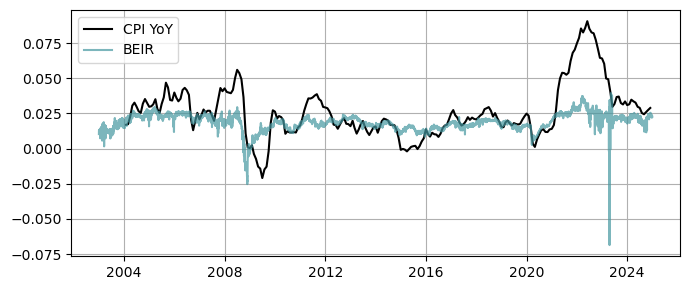

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)
ax.plot(cpi["YoY"], color="black", label="CPI YoY")
ax.plot(beir_daily.iloc[:,0], color="#4597A0", alpha=0.7, label="BEIR")
ax.legend()
ax.grid()
plt.show()

## Implied Inflation

For a zero-coupon fixed-income security, that
$$P_{t,T}=\frac{VNA_{T}}{(1+R_{t,T})},$$
where $P_{t,T}$ is the price of the security at date $t$ with maturity at $T$, $VNA_T$ is the updated nominal value on the maturity date $T$ and $R_{t,T}$ is the nominal rate from $t$ to $T$.
We again use a zero-coupon NTN-B. Let $VNA_{t^*}$ be the last known VNA. The $VNA_T$ can be described as the last known VNA adjusted by inflation to maturity, with a lag of 15 calendar days. Thus:
$$P_{t,T}=\frac{VNA_{t^*}(1+II_{t^*-15,T-15})}{(1+R_{t,T})},$$
$$II_{t^*-15,T-15}=\frac{P_{t,T}(1+R_{t,T})}{VNA_{t^*}}-1$$ 
in which $II_{t*−15,T-15}$ is the implied inflation embedded in the bond with a 15-calendar-day lag between $t*$ and the maturity $T$.

### 名目カーブ
- 名目ゼロスポット金利$R_{t,T}$(日次連続 カーブ).
### 実質カーブ
- 実質利回り$r_{t,T}^{CPI}$(日次連続 カーブ).
### 合成ゼロ価格
- ゼロクーポン化したインフレ連動債価格$P_{t,T}$.
$$P_{t,T}=\frac{VNA_{t}}{1+r_{t,T}^{CPI}}$$